# Quantum Neural Network Approximating Functions

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

# Overview
Quantum neural network (QNN) is a common quantum machine learning model that consists of parameterized quantum circuits. By tuning parameters of quantum circuits, a QNN is able to minimize an objective function of interest. Similar to the Neural Network (NN) model in machine learning, the expressivity of QNN is characterized by the function classes that it can approximate. The Universal Approximation Theorem (UAT) in machine learning theory describes the ability of multi-layer NNs to approximate any function. In recent times, the universal approximation property (UAP) of multi-qubit QNN models has been investigated by correlating QNN to Fourier series [1]. However, the expressivity of single-qubit QNNs remains an open problem. In our recent paper [2], we prove that single-qubit QNNs can approximate any univariate function, by exploring connections to quantum signal processing, which solve this open problem. In this tutorial, we demonstrate how to use single-qubit QNNs to approximate any target function.

# Single-qubit QNN approximating any even function
We use data re-uploading single-qubit QNNs that consist of interleaved data encoding gates and trainable gates. Both the data encoding gates and trainable gates are selected from the Pauli rotation gates $\{ R_X,R_Y,R_Z \}$. Let the initial state be $|0\rangle$，we define the output of the QNN be the measurement results of some observables $M$,

$$
f_U(x) = \langle 0| U^\dagger M U |0\rangle, \tag{1}
$$

where $x$ is the input data and $U$ denotes the QNN.

First, let us consider the simplest case, i.e. choosing $R_Z$ as the data encoding gates and $R_Y$ as the trainable gate. We define the single-qubit QNN as follow,

$$
U^{\mathit{YZY}}_{\mathbf{\theta}, L}(x) = R_Y(\theta_0) \sum_{j=1}^LR_Z(x)R_Y(\theta_j), \tag{2}
$$

where $\mathbf{\theta} := (\theta_0, \ldots, \theta_L)$ is the set of trainable parameters and $L$ denotes the number of layers.

We prove that a single-qubit QNN $U^{\mathit{YZY}}_{\mathbf{\theta}, L}(x)$ can represent Fourier series

$$
\langle 0|U^{\mathit{YZY}}_{\mathbf{\theta}, L}(x) |0\rangle = a_0 + \sum_{j=1}^{L}a_j\cos(nx). \tag{3}
$$
When choosing the observable as the Pauli operator $Z$，the output of this QNN can approximate any square-integrable even function $f: [-\pi, \pi] \to [-1, 1]$.

Now we numerically simulate the single-qubit QNN approximation on Paddle Quantum to verify the results. First we import the required packages.

In [15]:
import paddle
import numpy as np
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.hamiltonian import Hamiltonian
from paddle_quantum.loss import ExpecVal
import matplotlib.pyplot as plt
import brewer2mpl
import matplotlib
# set the backend to state vector mode
paddle_quantum.set_backend("state_vector")

We define a function to construct the corresponding QNN, consisting of interleaved data encoding gates $R_Z$ and trainable gates $R_Y$.

In [16]:
# Construct the parameterized quantum circuit in YZY structure.
def U_YZY(train_block, w_theta, x):
    cir = Circuit(1)
    for i in range(train_block):
        cir.ry(0, param=w_theta[i])
        cir.rz(0, param=x)  # input data
    cir.ry(0, param=w_theta[-1])
    return cir

Let a damping function $f(x) = \sin(5x)/5x$ be the target function, and we need to sample data points used for training.

In [17]:
# Define the target function
def target_func(x):
    return np.sin(5 * x) / (5 * x)

# Randomly sample data points from the target function.
def get_data():
    x_plot = np.arange(0, np.pi, np.pi/1000)
    y_plot = target_func(x_plot)
    
    np.random.seed(0)
    x_all = np.random.uniform(0, np.pi, 300)
    
    y_all = np.sin(5*x_all) / (5*x_all)

    x_train, y_train = x_all[:200], y_all[:200]
    x_test, y_test = x_all[200:], y_all[200:]

    return x_train, y_train, x_test, y_test, x_plot, y_plot
    
# Get the training set and test set
x_train, y_train, x_test, y_test, x_plot, y_plot = get_data()

C:\Users\yuzhan01\AppData\Local\Temp\ipykernel_26936\3212922392.py:8: RuntimeWarning: invalid value encountered in true_divide
  y_plot = np.sin(5*x_plot) / (5*x_plot)


Next we define the QNN training model and a training function.

In [18]:
class QNN(paddle.nn.Layer):
    def __init__(self, 
                 train_block,           # L layer
                 SEED=0,
                 dtype='float64'):
        super(QNN, self).__init__()
        self.train_block = train_block
        paddle.seed(SEED)
        # initiate trainable parameter 
        self.w_theta = self.create_parameter(
            shape=[(train_block+1)],
            default_initializer=paddle.nn.initializer.Uniform(0.0, 2 * np.pi),
            dtype=dtype,
            is_bias=False)


    def forward(self, x):
        """
        Forward propagation
        """
        predict = []
        H = Hamiltonian([(1.0, "z0")])
        out_func = ExpecVal(H)
        x = paddle.to_tensor(x, dtype='float64')
        if len(x.shape) == 1:  # 1-dimension data
            x = x.reshape((-1, 1))
        for i in range(x.shape[0]):
            cir = U_YZY(self.train_block, self.w_theta, x[i])
            # Run the quantum circuit
            out_state = cir()
            predict.append(out_func(out_state))
        return paddle.concat(predict).reshape((-1,)), cir


# Training
def train_qnn(x, y, train_block, LR, ITR, SEED, BATCHSIZE=20):
    model = QNN(train_block, SEED)
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    loss_list = []
    x = paddle.to_tensor(x, dtype='float64')
    y = paddle.to_tensor(y, dtype='float64')
    for ep in range(1, ITR + 1):
        # Select batch of data
        for itr in range(len(x) // BATCHSIZE):
            x_batch = x[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            y_batch = y[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            # Run the network defined above
            predict, cir = model(x_batch)
            avg_loss = paddle.mean((predict - y_batch) ** 2)
            loss_list.append(avg_loss.numpy())
            # Calculate the gradient and optimize
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_grad()
            if (itr+1) % 5 == 0:
                print("qnn:epoch:", ep,"qnn:iter:", (itr+1), " train  loss:", "%.8f" % avg_loss.numpy())

    return model, loss_list

We use a 10-layer QNN to approximate the target function. Before training, we need to set some hyper-parameters for the optimizer.

In [19]:
SEED = 4096
QITR = 10
QLR = 0.1
train_block = 10
modelL10, loss_listL10 = train_qnn(x_train, y_train, train_block=train_block, LR=QLR, ITR=QITR, SEED=SEED)
predictL10 = modelL10(x_test)

c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\fluid\dygraph\math_op_pa

qnn:epoch: 1 qnn:iter: 5  train  loss: 0.12315345
qnn:epoch: 1 qnn:iter: 10  train  loss: 0.06922857
qnn:epoch: 2 qnn:iter: 5  train  loss: 0.02042443
qnn:epoch: 2 qnn:iter: 10  train  loss: 0.04707706
qnn:epoch: 3 qnn:iter: 5  train  loss: 0.01874223
qnn:epoch: 3 qnn:iter: 10  train  loss: 0.01295448
qnn:epoch: 4 qnn:iter: 5  train  loss: 0.00991240
qnn:epoch: 4 qnn:iter: 10  train  loss: 0.00303511
qnn:epoch: 5 qnn:iter: 5  train  loss: 0.00157935
qnn:epoch: 5 qnn:iter: 10  train  loss: 0.00089821
qnn:epoch: 6 qnn:iter: 5  train  loss: 0.00046386
qnn:epoch: 6 qnn:iter: 10  train  loss: 0.00054655
qnn:epoch: 7 qnn:iter: 5  train  loss: 0.00059435
qnn:epoch: 7 qnn:iter: 10  train  loss: 0.00022313
qnn:epoch: 8 qnn:iter: 5  train  loss: 0.00028409
qnn:epoch: 8 qnn:iter: 10  train  loss: 0.00017835
qnn:epoch: 9 qnn:iter: 5  train  loss: 0.00017996
qnn:epoch: 9 qnn:iter: 10  train  loss: 0.00018871
qnn:epoch: 10 qnn:iter: 5  train  loss: 0.00016455
qnn:epoch: 10 qnn:iter: 10  train  loss:

After training, we plot the approximation result.

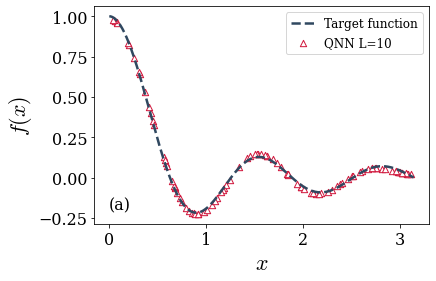

In [21]:
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["mathtext.fontset"] = "cm"
bmap = brewer2mpl.get_map("Set1", "qualitative", 7)
colors = bmap.mpl_colors

plt.plot(x_plot, y_plot, color="#304860", ls="--", lw=2.5, label="Target function")

plt.scatter(
        x_test,
        predictL10[0].numpy(),
        s=40,
        marker="^",
        facecolor="white",
        color="#D1193E",
        label="QNN L=10",
    )
plt.xlabel(r"$x$", fontdict={"size": 22})
plt.ylabel(r"$f(x)$", fontdict={"size": 22})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(prop={"size": 12})
plt.text(0, -0.2, r"(a)", fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

From the result, we can see that using a 10-layer QNN with YZY structure is able to approximate the target function in a high precision, which verifies the theoretical result on the expressivity of QNNs.

# Single-qubit QNN approximating any function

Now that $U^{\mathit{YZY}}_{\mathbf{\theta}, L}$ can approximate any even function, can we make some changes so that it can approximate any function?
Actually, we just need to introduce $\sin$ terms to complete the Fourier series, by adding an extra trainable gate $R_Z$ in each layer. We define a new QNN as follow:

$$
U^{\mathit{WZW}}_{\mathbf{\theta},\mathbf{\phi}, L}(x) = R_Y(\theta_0)R_Z(\phi_0) \sum_{j=1}^L R_Z(x) R_Y(\theta_j)R_Z(\phi_j), \tag{4}
$$

where $\mathbf{\theta} := (\theta_0, \ldots, \theta_L)$ and $\mathbf{\phi} := (\phi_0, \ldots, \phi_L)$ are trainable parameters，$L$ denotes the number of layers. We proved that this QNN can represent the Fourier series,

$$
\langle 0|U^{\mathit{WZW}}_{\mathbf{\theta},\mathbf{\phi}, L}(x) |0\rangle = a_0 + \sum_{j=1}^{L}(a_j\cos(nx)+ b_j\sin(nx)), \tag{5}
$$

and it can approximate any square-integrable function $f: [-\pi, \pi] \to [-1, 1]$.

Then we use the single-qubit QNN to approximate a square-wave function on Paddle Quantum to verify the results. First define a function to construct the corresponding QNN $U^{\mathit{WZW}}_{\mathbf{\theta},\mathbf{\phi}, L}$.

In [8]:
def U_WZW(train_block, w_theta, x):
    cir = Circuit(1)
    for i in range(train_block):
        cir.rz(0, param=w_theta[i][1])
        cir.ry(0, param=w_theta[i][0])
        cir.rz(0, param=x)  # input data
    cir.rz(0, param=w_theta[-1][1])
    cir.ry(0, param=w_theta[-1][0])
    return cir

Same as in previous section, we need to define the target function and sample data points used for training.

In [9]:
def square_wave(trunk):
    x_train = np.linspace(0, 20, 400)
    x_test = np.linspace(0.02, 30, 150)

    def func(x):
        cof = 0
        for i in range(1, trunk+1, 2):
            cof = cof + 4*np.sin(i*x)/(i*np.pi)
        y_max = max(cof)
        cof /= y_max
        return cof
    
    y_train = func(x_train)
    y_test = func(x_test)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = square_wave(10000)

Next we define the QNN training model and a training function.

In [10]:
class QNN(paddle.nn.Layer):
    def __init__(self, 
                 train_block,           # L layer
                 SEED=0,
                 dtype='float64'):
        super(QNN, self).__init__()
        self.train_block = train_block
        paddle.seed(SEED)
        # initiate trainable parameter 
        self.w_theta = self.create_parameter(
            shape=[(train_block+1), 2],
            default_initializer=paddle.nn.initializer.Uniform(0.0, 2*np.pi),
            dtype=dtype,
            is_bias=False)


    def forward(self, x):
        """
        Forward propagation
        """
        predict = []
        H = Hamiltonian([(1.0, "z0")])
        out_func = ExpecVal(H)
        x = paddle.to_tensor(x, dtype='float64')
        if len(x.shape) == 1:  # 1-dimension data
            x = x.reshape((-1, 1))
        for i in range(x.shape[0]):
            cir = U_WZW(self.train_block, self.w_theta, x[i])
            # Run the quantum circuit
            out_state = cir()
            predict.append(out_func(out_state))
        return paddle.concat(predict).reshape((-1,)), cir


# Training
def train_qnn(x, y, train_block, LR, ITR, SEED, BATCHSIZE=40):
    model = QNN(train_block, SEED)
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=model.parameters())
    loss_list = []
    x = paddle.to_tensor(x, dtype='float64')
    y = paddle.to_tensor(y, dtype='float64')
    for ep in range(1, ITR + 1):
        # Select batch of data
        for itr in range(len(x) // BATCHSIZE):
            x_batch = x[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            y_batch = y[itr * BATCHSIZE:(itr + 1) * BATCHSIZE]
            # Run the network defined above
            predict, cir = model(x_batch)
            avg_loss = paddle.mean((predict - y_batch) ** 2)
            loss_list.append(avg_loss.numpy())
            # Calculate the gradient and optimize
            avg_loss.backward()
            opt.minimize(avg_loss)
            opt.clear_grad()
            if (itr+1) % 5 == 0:
                print("qnn:epoch:", ep,"qnn:iter:", (itr+1), " train  loss:", "%.8f" % avg_loss.numpy())

    return model, loss_list

We use a 45-layer QNN to approximate the square-wave function. Note that the number of layers required for precise approximate is related to the truncation error for Fourier series. Usually more layers leads to better approximation results.

In [11]:
SEED = 2
QITR = 10
QLR = 0.1
train_block = 45
modelL45, loss_listL45 = train_qnn(x_train, y_train, train_block=train_block, LR=QLR, ITR=QITR, SEED=SEED)
predictL45 = modelL45(x_test)

c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\fluid\framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
c:\Users\yuzhan01\Miniconda3\envs\pq_new\lib\site-packages\paddle\fluid\dygraph\math_op_pa

qnn:epoch: 1 qnn:iter: 5  train  loss: 1.35621011
qnn:epoch: 1 qnn:iter: 10  train  loss: 1.06700826
qnn:epoch: 2 qnn:iter: 5  train  loss: 1.59428942
qnn:epoch: 2 qnn:iter: 10  train  loss: 0.32698074
qnn:epoch: 3 qnn:iter: 5  train  loss: 0.30190033
qnn:epoch: 3 qnn:iter: 10  train  loss: 0.09284516
qnn:epoch: 4 qnn:iter: 5  train  loss: 0.11605076
qnn:epoch: 4 qnn:iter: 10  train  loss: 0.06084419
qnn:epoch: 5 qnn:iter: 5  train  loss: 0.10283329
qnn:epoch: 5 qnn:iter: 10  train  loss: 0.07899086
qnn:epoch: 6 qnn:iter: 5  train  loss: 0.06403162
qnn:epoch: 6 qnn:iter: 10  train  loss: 0.05624062
qnn:epoch: 7 qnn:iter: 5  train  loss: 0.05701165
qnn:epoch: 7 qnn:iter: 10  train  loss: 0.05501990
qnn:epoch: 8 qnn:iter: 5  train  loss: 0.05415571
qnn:epoch: 8 qnn:iter: 10  train  loss: 0.05919911
qnn:epoch: 9 qnn:iter: 5  train  loss: 0.05508716
qnn:epoch: 9 qnn:iter: 10  train  loss: 0.05666707
qnn:epoch: 10 qnn:iter: 5  train  loss: 0.05592950
qnn:epoch: 10 qnn:iter: 10  train  loss:

Then we plot to show the approximation results.

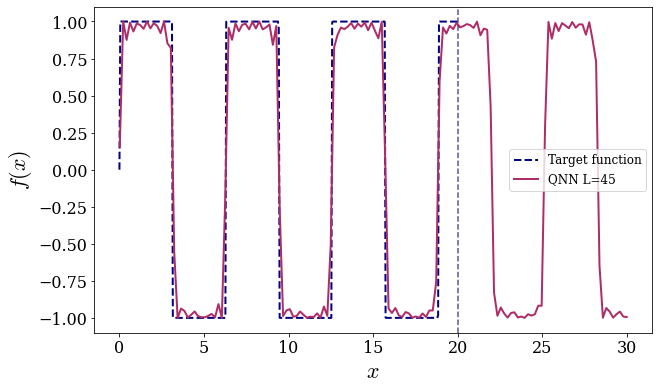

<Figure size 432x288 with 0 Axes>

In [13]:
fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
ax1.plot(x_train, y_train, label='Target function', color='#000181', lw=2, linestyle='--')
ax1.plot(x_test, predictL45[0].numpy(), label='QNN L=45', color='#AE2D68', lw=2,linestyle='-')
ax1.axvline(20, alpha=0.7,ls='--',c='#280659')
ax1.set_xlabel(r'$x$', fontdict={'size':22})
ax1.set_ylabel(r'$f(x)$', fontdict={'size':22})
plt.tick_params(labelsize=16)
ax1.legend(prop={'size': 12})
plt.show()

The single qubit QNN can approximate the target square-wave function that is arguably hard to approximate by classical NNs, which verifies the theoretical results.

---
## Reference

[1] Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. "Effect of data encoding on the expressive power of variational quantum-machine-learning models." [Physical Review A 103.3 (2021): 032430.](https://doi.org/10.1103/PhysRevA.103.032430)

[2] Yu, Zhan, et al. "Power and limitations of single-qubit native quantum neural networks." [arXiv preprint arXiv:2205.07848 (2022).](https://doi.org/10.48550/arXiv.2205.07848)